In [3]:
import torch
import os, pickle
import numpy as np
import evaluate
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
from torchinfo import summary
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch import nn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm

In [11]:
# Load the pre-trained model
base_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")

# Update the configuration
config = base_model.config
config.num_channels = 18
config.num_labels = 2

# Initialize the new model with the updated configuration
model = SegformerForSemanticSegmentation(config)

# Load the state dictionary from the pre-trained model into the new model
pretrained_dict = base_model.state_dict()
model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_dict)

# Added batch size to input_size
summary(model, input_size=(1, 18, 128, 128))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                                      Output Shape              Param #
SegformerForSemanticSegmentation                                            [1, 2, 32, 32]            --
├─SegformerModel: 1-1                                                       [1, 32, 32, 32]           --
│    └─SegformerEncoder: 2-1                                                [1, 32, 32, 32]           --
│    │    └─ModuleList: 3-10                                                --                        (recursive)
│    │    └─ModuleList: 3-11                                                --                        (recursive)
│    │    └─ModuleList: 3-12                                                --                        (recursive)
│    │    └─ModuleList: 3-10                                                --                        (recursive)
│    │    └─ModuleList: 3-11                                                --                        (recursive)
│    

In [12]:
print(model.config)

SegformerConfig {
  "_name_or_path": "nvidia/mit-b0",
  "architectures": [
    "SegformerForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 256,
  "depths": [
    2,
    2,
    2,
    2
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_sizes": [
    32,
    64,
    160,
    256
  ],
  "image_size": 224,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-06,
  "mlp_ratios": [
    4,
    4,
    4,
    4
  ],
  "model_type": "segformer",
  "num_attention_heads": [
    1,
    2,
    5,
    8
  ],
  "num_channels": 18,
  "num_encoder_blocks": 4,
  "patch_sizes": [
    7,
    3,
    3,
    3
  ],
  "reshape_last_stage": true,
  "semantic_loss_ignore_index": 255,
  "sr_ratios": [
    8,
    4,
    2,
    1
  ],
  "strides": [
    4,
    2,
    2,
    2
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.43

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_input  = torch.randn(1, 18, 128, 128).to(device)

output = model(test_input)

print(output.logits.shape)

torch.Size([1, 2, 32, 32])


In [1]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset

def get_indices(arr):
    if arr.ndim != 3 or arr.shape[2] < 7:
        raise ValueError("Input array must be 3-dimensional with at least 7 channels.")
    
    bands = {
        "ndvi": (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + arr[:, :, 3] + 1e-7),
        "evi": 2.5 * (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + 6 * arr[:, :, 3] - 7.5 * arr[:, :, 1] + 1),
        "savi": 1.5 * (arr[:, :, 4] - arr[:, :, 3]) / (arr[:, :, 4] + arr[:, :, 3] + 0.5),
        "msavi": 0.5 * (2 * arr[:, :, 4] + 1 - np.sqrt((2 * arr[:, :, 4] + 1) ** 2 - 8 * (arr[:, :, 4] - arr[:, :, 3]))),
        "ndmi": (arr[:, :, 4] - arr[:, :, 5]) / (arr[:, :, 4] + arr[:, :, 5] + 1e-7),
        "nbr": (arr[:, :, 4] - arr[:, :, 6]) / (arr[:, :, 4] + arr[:, :, 6] + 1e-7),
        "nbr2": (arr[:, :, 5] - arr[:, :, 6]) / (arr[:, :, 5] + arr[:, :, 6] + 1e-7),
    }
    for name in bands:
        value = np.nan_to_num(bands[name])
        arr = np.dstack((arr, value))
    return arr

def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val + 1e-7)

class SlidingWindowDataset(Dataset):
    def __init__(self, pickle_dir, window_size=128, stride=64, reduce_indices=False):
        self.pickle_dir = pickle_dir
        self.window_size = window_size
        self.stride = stride
        self.reduce_indices = reduce_indices
        self.processed_images, self.processed_masks = self._process_data()

    def _process_data(self):
        processed_images = []
        processed_masks = []
        
        for file_name in os.listdir(self.pickle_dir):
            if file_name.endswith('.pkl'):
                with open(os.path.join(self.pickle_dir, file_name), 'rb') as f:
                    img, mask = pickle.load(f, encoding='latin1')
                
                if img.ndim == 3 and img.shape[2] >= 7:
                    img = get_indices(img)
                    img = normalize_image(img)
                    h, w, _ = img.shape
                    for i in range(0, h - self.window_size + 1, self.stride):
                        for j in range(0, w - self.window_size + 1, self.stride):
                            window_img = img[i:i + self.window_size, j:j + self.window_size]
                            window_mask = mask[i:i + self.window_size, j:j + self.window_size]
                            class_0_ratio = np.sum(window_mask == 0) / window_mask.size
                            class_1_ratio = np.sum(window_mask == 1) / window_mask.size
                            class_2_ratio = np.sum(window_mask == 2) / window_mask.size
                            if class_0_ratio < 0.5:
                                if class_2_ratio > 0.4:
                                    # Augment the image by rotating it 90 degrees 3 times
                                    for _ in range(3):
                                        window_img = np.rot90(window_img).copy()
                                        window_mask = np.rot90(window_mask).copy()
                                        processed_images.append(window_img)
                                        processed_masks.append(window_mask)
                                else:
                                    processed_images.append(window_img)
                                    processed_masks.append(window_mask)
                else:
                    print(f"Skipping image with shape {img.shape} in file {file_name}")
        
        return processed_images, processed_masks

    def __len__(self):
        return len(self.processed_images)

    def __getitem__(self, idx):
        image = self.processed_images[idx]
        mask = self.processed_masks[idx]
        
        if mask.dtype == np.uint16:
            mask = mask.astype(np.int64)
            
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW
        mask = torch.tensor(mask, dtype=torch.long)
        
        if self.reduce_indices:
            mask = mask - 1
            mask[mask == -1] = 255

        encoded_data = {
            'pixel_values': image,
            'labels': mask
        }

        return encoded_data

In [4]:
root_dir = 'data/train/training_2015_pickled_data'

dataset = SlidingWindowDataset(pickle_dir=root_dir, window_size=128, reduce_indices=True)

SEED = 123
BATCH_SIZE = 8
TRAIN_DEV_TEST_SPLIT = (0.8, 0.1, 0.1)

generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset, test_dataset = random_split(dataset, TRAIN_DEV_TEST_SPLIT, generator)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [17]:
batch = next(iter(train_dataloader))

In [18]:
# Take a mask and check if it has any values other than 0 and 1
mask = batch['labels']
image = batch['pixel_values']

print(torch.unique(mask))
print(mask.shape)
print(torch.max(image), torch.min(image))

tensor([  0,   1, 255])
torch.Size([8, 128, 128])
tensor(1.) tensor(0.)


In [19]:
# Take a mask and check if it has any values other than 0 and 1
mask = batch['labels']

print(torch.unique(mask))

tensor([  0,   1, 255])


In [5]:
print(len(dataset))

# 2458

3922


In [25]:
import torch
from collections import Counter
import numpy as np

def calculate_class_distribution(dataloader):
    class_counts = Counter()
    total_pixels = 0

    for batch in dataloader:
        labels = batch['labels']
        if isinstance(labels, torch.Tensor):
            labels = labels.numpy()
        unique, counts = np.unique(labels, return_counts=True)
        class_counts.update(dict(zip(unique, counts)))
        total_pixels += labels.size

    class_distribution = {cls: (count / total_pixels) * 100 for cls, count in class_counts.items()}
    
    return class_distribution

# Example usage:
# Assuming `dataloader` is your DataLoader object
class_distribution = calculate_class_distribution(test_dataloader)
print(class_distribution)

{0: 57.31570185447226, 1: 39.25057236029178, 255: 3.4337257852359695}


In [21]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Define model directory
model_dir = "model/model_1"

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the metric functions
def compute_accuracy_ignore_background(preds, labels, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    accuracy = (preds == labels).mean()
    return accuracy

def compute_miou_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    ious = []
    for cls in range(num_classes):
        if cls == ignore_index:
            continue
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

def compute_precision_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    precision_per_class = precision_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': precision for i, precision in enumerate(precision_per_class) if i != ignore_index}

def compute_recall_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    recall_per_class = recall_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': recall for i, recall in enumerate(recall_per_class) if i != ignore_index}

def compute_f1_per_class_ignore_background(preds, labels, num_classes, ignore_index=255):
    preds = preds.cpu().numpy().flatten()
    labels = labels.cpu().numpy().flatten()
    mask = labels != ignore_index
    preds = preds[mask]
    labels = labels[mask]
    
    f1_per_class = f1_score(labels, preds, average=None, labels=range(num_classes), zero_division=0)
    return {f'class_{i}': f1 for i, f1 in enumerate(f1_per_class) if i != ignore_index}

# Initialize the exponentially weighted average loss
ewma_loss = None
alpha = 0.1  # Smoothing factor
learning_rate_decay = 0.99

model.train()
for epoch in range(10):  # loop over the dataset multiple times
    losses = []
    accuracies = []
    mious = []
    precisions = []
    recalls = []
    f1_scores = []
    print("Epoch:", epoch + 1)
    t = tqdm(enumerate(train_dataloader))
    for idx, batch in t:
        # Get the inputs
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # Update the exponentially weighted average loss
        if ewma_loss is None:
            ewma_loss = loss.item()
        else:
            ewma_loss = alpha * loss.item() + (1 - alpha) * ewma_loss

        # Evaluate
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)

            # Calculate metrics
            accuracy = compute_accuracy_ignore_background(predicted, labels)
            miou = compute_miou_ignore_background(predicted, labels, num_classes=2)
            precision_per_class = compute_precision_per_class_ignore_background(predicted, labels, num_classes=2)
            recall_per_class = compute_recall_per_class_ignore_background(predicted, labels, num_classes=2)
            f1_per_class = compute_f1_per_class_ignore_background(predicted, labels, num_classes=2)

        losses.append(loss.item())
        accuracies.append(accuracy)
        mious.append(miou)
        precisions.append(precision_per_class)
        recalls.append(recall_per_class)
        f1_scores.append(f1_per_class)

        # Print loss and metrics every batch
        t.set_postfix(Loss=f"{ewma_loss:.4f}", Accuracy=f"{accuracy:.4f}", mIoU=f"{miou:.4f}")
        t.update()

    # Print loss and metrics every epoch
    print(f"Loss: {np.mean(losses):.4f}, Accuracy: {np.mean(accuracies):.4f}, mIoU: {np.nanmean(mious):.4f}")
    print(f"Precision: {np.nanmean([list(p.values()) for p in precisions], axis=0)}")
    print(f"Recall: {np.nanmean([list(r.values()) for r in recalls], axis=0)}")
    print(f"F1 Score: {np.nanmean([list(f.values()) for f in f1_scores], axis=0)}")

    # Update the learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] *= learning_rate_decay

print('Finished Training')
print(f"saving model in {model_dir}")
model.save_pretrained(model_dir)    # Save the model

Epoch: 1


100%|██████████| 393/393 [06:08<00:00,  1.07it/s, Accuracy=0.4374, Loss=0.6610, mIoU=0.2187]


Loss: 0.6826, Accuracy: 0.5677, mIoU: 0.3203
Precision: [0.58618183 0.43273123]
Recall: [0.88104621 0.12872582]
F1 Score: [0.69542857 0.16966324]
Epoch: 2


100%|██████████| 393/393 [06:22<00:00,  1.03it/s, Accuracy=0.4716, Loss=0.6802, mIoU=0.2530]


Loss: 0.6779, Accuracy: 0.5755, mIoU: 0.3093
Precision: [0.58650566 0.44000842]
Recall: [0.944329   0.06730153]
F1 Score: [0.71558512 0.09605756]
Epoch: 3


100%|██████████| 393/393 [09:33<00:00,  1.46s/it, Accuracy=0.6858, Loss=0.6495, mIoU=0.3949]


Loss: 0.6742, Accuracy: 0.5793, mIoU: 0.3102
Precision: [0.58896034 0.46026174]
Recall: [0.94472621 0.07023627]
F1 Score: [0.71729786 0.09182348]
Epoch: 4


100%|██████████| 393/393 [06:03<00:00,  1.08it/s, Accuracy=0.7346, Loss=0.6658, mIoU=0.3673]


Loss: 0.6743, Accuracy: 0.5799, mIoU: 0.3116
Precision: [0.59047815 0.45646758]
Recall: [0.93965467 0.07865905]
F1 Score: [0.71525307 0.09837749]
Epoch: 5


100%|██████████| 393/393 [05:35<00:00,  1.17it/s, Accuracy=0.7414, Loss=0.6618, mIoU=0.3749]


Loss: 0.6701, Accuracy: 0.5915, mIoU: 0.3340
Precision: [0.60104481 0.5279304 ]
Recall: [0.92684008 0.12670811]
F1 Score: [0.71858325 0.16221667]
Epoch: 6


100%|██████████| 393/393 [05:41<00:00,  1.15it/s, Accuracy=0.7735, Loss=0.6047, mIoU=0.6140]


Loss: 0.6536, Accuracy: 0.6216, mIoU: 0.4070
Precision: [0.63564181 0.59196936]
Recall: [0.84651528 0.31683623]
F1 Score: [0.71696992 0.38562539]
Epoch: 7


100%|██████████| 393/393 [05:41<00:00,  1.15it/s, Accuracy=0.7138, Loss=0.6100, mIoU=0.5262]


Loss: 0.6331, Accuracy: 0.6451, mIoU: 0.4445
Precision: [0.66016044 0.61581864]
Recall: [0.82610561 0.4065964 ]
F1 Score: [0.72503297 0.46711264]
Epoch: 8


100%|██████████| 393/393 [06:01<00:00,  1.09it/s, Accuracy=0.4928, Loss=0.6245, mIoU=0.3269]


Loss: 0.6109, Accuracy: 0.6649, mIoU: 0.4768
Precision: [0.68375241 0.63035478]
Recall: [0.80250602 0.48590928]
F1 Score: [0.73068678 0.53371038]
Epoch: 9


100%|██████████| 393/393 [05:36<00:00,  1.17it/s, Accuracy=0.3225, Loss=0.6284, mIoU=0.1858]


Loss: 0.5991, Accuracy: 0.6707, mIoU: 0.4895
Precision: [0.69987301 0.62510958]
Recall: [0.77237938 0.54471822]
F1 Score: [0.72605899 0.5676153 ]
Epoch: 10


100%|██████████| 393/393 [05:20<00:00,  1.23it/s, Accuracy=0.4067, Loss=0.6402, mIoU=0.2464]

Loss: 0.6004, Accuracy: 0.6730, mIoU: 0.4924
Precision: [0.70268973 0.62588789]
Recall: [0.77250632 0.55159472]
F1 Score: [0.72784051 0.57066851]
Finished Training
saving model in model/model_1


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate on the validation set
model.eval()

accuracies = []
mious = []
precisions = []
recalls = []
f1_scores = []

with torch.no_grad():
    for batch in tqdm(train_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        # Calculate metrics
        accuracy = compute_accuracy_ignore_background(predicted, labels)
        miou = compute_miou_ignore_background(predicted, labels, num_classes=2)
        precision_per_class = compute_precision_per_class_ignore_background(predicted, labels, num_classes=2)
        recall_per_class = compute_recall_per_class_ignore_background(predicted, labels, num_classes=2)
        f1_per_class = compute_f1_per_class_ignore_background(predicted, labels, num_classes=2)

        accuracies.append(accuracy)
        mious.append(miou)
        precisions.append(precision_per_class)
        recalls.append(recall_per_class)
        f1_scores.append(f1_per_class)

    # Print loss and metrics every epoch
    print(f"Precision: {np.nanmean([list(p.values()) for p in precisions], axis=0)}")
    print(f"Recall: {np.nanmean([list(r.values()) for r in recalls], axis=0)}")
    print(f"F1 Score: {np.nanmean([list(f.values()) for f in f1_scores], axis=0)}")

100%|██████████| 393/393 [02:28<00:00,  2.65it/s]

Precision: [0.58540477 0.20937885]
Recall: [0.99948338 0.00374095]
F1 Score: [0.73276145 0.00718345]


100%|██████████| 49/49 [00:07<00:00,  6.53it/s]


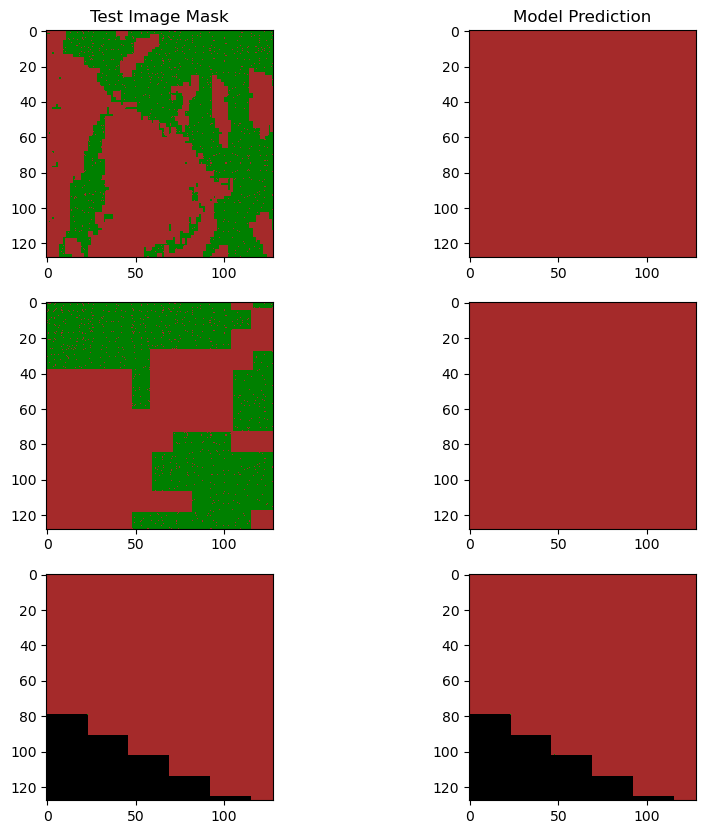

In [23]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        # Set predictions to 255 wherever the ignore class is present in the labels
        predicted[labels == 255] = 255

        all_preds.append(predicted.detach().cpu())
        all_labels.append(labels.detach().cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Flatten the tensors
all_preds_flat = all_preds.flatten()
all_labels_flat = all_labels.flatten()

# Mask to ignore the ignore_index
ignore_index = 255
mask = all_labels_flat != ignore_index

# Filter out the ignore_index
filtered_preds = all_preds_flat[mask]
filtered_labels = all_labels_flat[mask]

# Define the colors for each specific value
colors = ['brown', 'green', 'black']

# Create a colormap
cmap = ListedColormap(colors)

# Define the boundaries for the values
boundaries = [0, 1, 2, 3]  # 0-1 -> black, 1-2 -> brown, 2-3 -> green

# Create a normalization
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Plot a test image mask and the model's prediction
idx = 4
rows = 3

fig, ax = plt.subplots(rows, 2, figsize=(10, 10))

ax[0][0].set_title("Test Image Mask")
ax[0][1].set_title("Model Prediction")
for i in range(rows):
    ax[i][0].imshow(all_labels[idx * rows + i], cmap=cmap, norm=norm)
    ax[i][1].imshow(all_preds[idx * rows + i], cmap=cmap, norm=norm)

plt.show()

In [ ]:
all_preds[idx]

In [ ]:
model_list = os.listdir('Model')

# Get the last number of the model
model_list = sorted(model_list, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Save the model with the next number

MODEL_SAVE_PATH = f"Model/model_{int(model_list[-1].split('_')[-1].split('.')[0]) + 1}.pth"

model.save_pretrained

In [ ]:
# load model

model_num = 1

model = SegformerForSemanticSegmentation.from_pretrained(f"Model/model_{model_num}.pth")

In [ ]:
from transformers import SegformerImageProcessor